<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
:پروژه ی پنجم
</font>
</h1>
<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
قانون یادگیری بدون ناظر و تقویتی
</font>
</h1>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
  عرشیا ربیعی 
    
</font> 
</p>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
۶۱۰۳۹۸۱۲۵ 
    
</font> 
</p>

In [266]:
from pymonntorch import *
import torch
import matplotlib.pyplot as plt


In [96]:
settings = {'device' : 'cpu' , 'def_type' : torch.float32 }
torch.manual_seed(73)
N = 100
TIME = 500
DT = 1
TIME_WINDOW = 40
REGULAR_SPIKE = {'a' : 0.02 , 'b' : 0.2 , 'c' : -65 , 'd' : 8}
IB = {'a' : 0.02 , 'b' : 0.2 , 'c' : -55 , 'd' : 4}
CHATTERING = {'a' : 0.02 , 'b' : 0.2 , 'c' : -50 , 'd' : 2}
LOW_THRESHOLD_SPIKING = {'a' : 0.02 , 'b' : 0.25 , 'c' : -65 , 'd' : 2}
FAST_SPIKING = {'a' : 0.1 , 'b' : 0.2 , 'c' : -65 , 'd' : 2}
PARAMETER_CHOOSE = REGULAR_SPIKE

In [97]:
class Pattern:
    def __init__(self, time_window , r):
        self.time_window = time_window
        self.r = r
    def generate(self, size):
        spikes = np.random.poisson(size=(self.time_window, size)) * self.r
        p_rand = np.random.poisson(size=(self.time_window, size))
        pattern1 = (spikes < p_rand).astype(int)
        pattern2 = (spikes >= p_rand).astype(int)
        return (pattern1, pattern2)

p = Pattern(40 , 0.5)
pattern1 , pattern2 = p.generate(10)
pattern1

array([[0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
       [1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 1],
       [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 1,

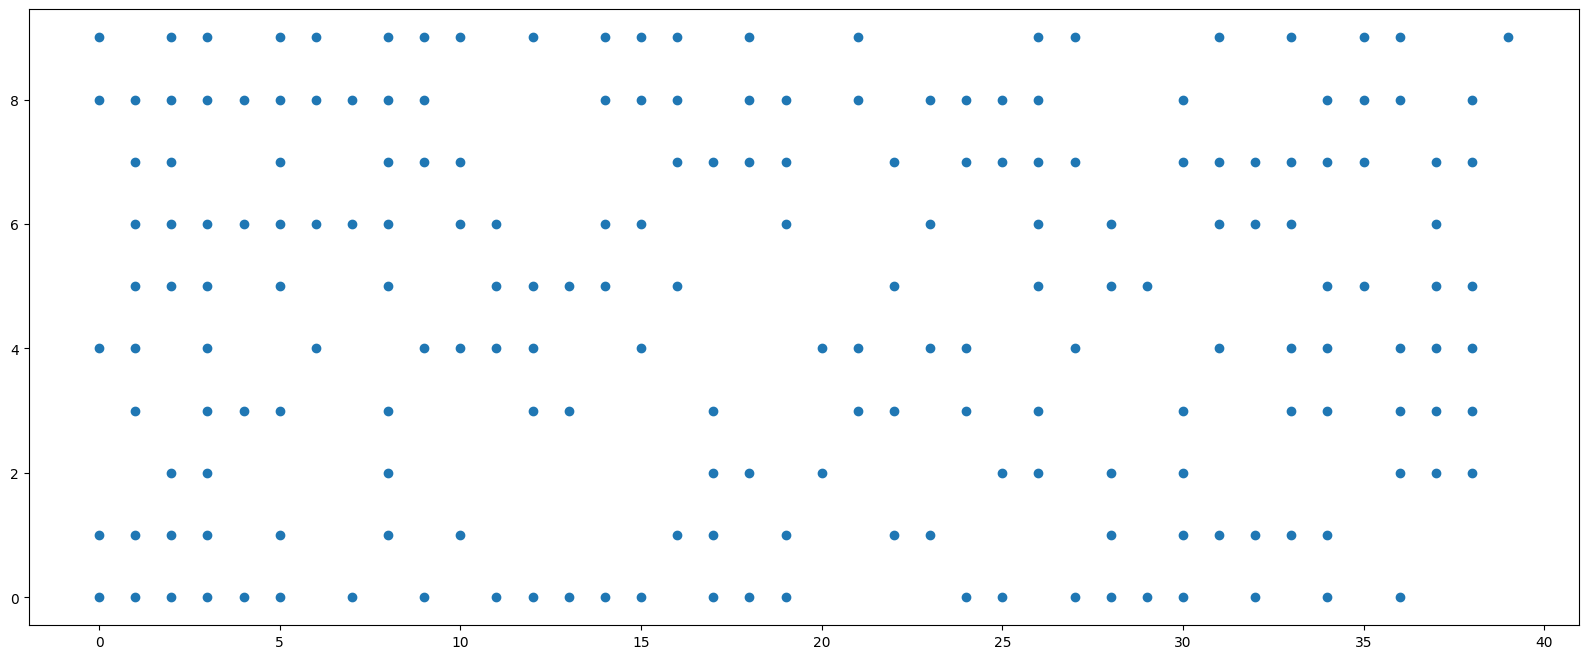

In [98]:
p = Pattern(40 , 0.5)
pattern1 , pattern2 = p.generate(10)
plt.figure(figsize=(20,8))
plt.scatter(np.nonzero(pattern1)[0], np.nonzero(pattern1)[1])
plt.show()

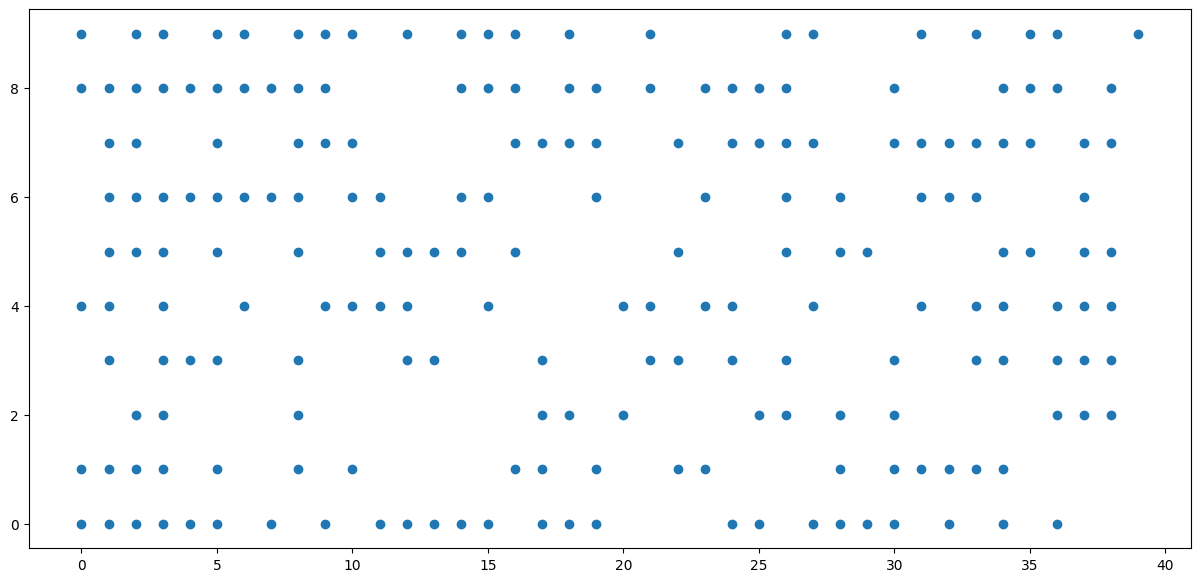

In [99]:
plt.figure(figsize=(15,7))
plt.scatter(np.nonzero(pattern1)[0], np.nonzero(pattern1)[1])
plt.show()

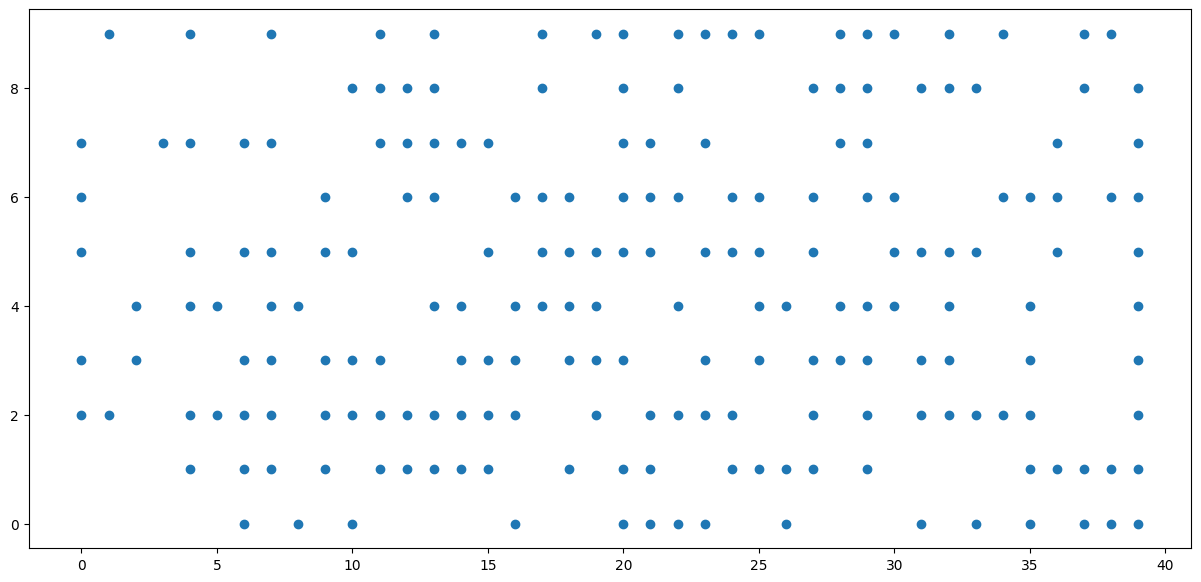

In [100]:
plt.figure(figsize=(15,7))
plt.scatter(np.nonzero(pattern2)[0], np.nonzero(pattern2)[1])
plt.show()

In [114]:
pattern2.shape

(40, 10)

In [292]:
class Time(Behavior):
    def initialize(self,network):
        network.dt = self.parameter('dt' , DT)
        network.passed = 0
        network.time_window = self.parameter('time_window' , None , required=True)
    def forward(self , network):
        network.passed += network.dt

In [293]:
class Dendrite(Behavior):
    def initialize(self , n):
        n.I = n.vector(mode='zeros')
    def forward(self, n):
        for syn in n.afferent_synapses['GLUTAMATE']:
            n.I += syn.I

In [294]:
class InputSynapse(Behavior):
    def initialize(self,syn):
        syn.W = syn.matrix('uniform' ,density = 1).T
        print('shapeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee    :   ' ,  syn.W.shape)
        self.coef = self.parameter('coef' , None)
    def forward(self , syn):
        pre_spike = syn.src.spike
        syn.I = torch.sum(syn.W[pre_spike],axis = 0)/syn.src.size * self.coef
        
        

In [295]:
class Izhikevich_Input(Behavior):
    def initialize(self , n):
        n.pattern1 = self.parameter('pattern1' , None , required=True)
        n.pattern2 = self.parameter('pattern2' , None , required=True)
        n.pattern1 = torch.from_numpy(n.pattern1)
        n.pattern2 = torch.from_numpy(n.pattern2)
        n.pattern0 = torch.zeros((n.network.time_window , 10))
        n.I = n.vector(mode='zeros')
        n.pattern = n.pattern1.clone()
#         print(n.pattern)
    def forward(self , n):
#         print(n.pattern1)
        if n.network.passed % n.network.time_window == 0:
            mod = np.random.randint(20) % 5
            if mod == 0 or mod == 1:
                n.pattern = n.pattern1.clone()
            elif mod == 2 or mod == 3:
                n.pattern = n.pattern2.clone()
            else:
                n.pattern = n.pattern0.clone()
#         print(n.pattern[n.network.passed % n.network.time_window].dtype)
        n.I[n.pattern[n.network.passed % n.network.time_window].type(torch.int64)] = 50

In [296]:
class Izhikevich(Behavior):
    def initialize(self , n):
        self.a = self.parameter('a' , None , required=True)
        self.b = self.parameter('b' , None , required=True)
        self.c = self.parameter('c' , None , required=True)
        self.d = self.parameter('d' , None , required=True)
        self.threshold = self.parameter('threshold' , 30)
        n.v = n.vector('uniform') * -70
        n.u = n.vector('uniform') * -15
        n.spike = n.v > self.threshold

    def _fire(self , n):
        self._spike(n)
        n.v[n.spike] = self.c
        n.u[n.spike] += self.d
    def _dv_du(self,n):
        self.dv = 0.04* (n.v**2) + 5*n.v + 140 - n.u + n.I
        self.du = self.a*(self.b * n.v - n.u)
    def _spike(self , n):
        n.spike = n.v > self.threshold
    def forward(self , n):
        self._dv_du(n)
        n.v += self.dv * n.network.dt
        n.u += self.du * n.network.dt
        self._fire(n)

In [297]:
class Flat_STDP(Behavior):
    
    def initialize(self, syn):
        self.add_tag("FlatSTDP")
        self.eta_d = self.parameter("eta_d", None)
        self.eta_p = self.parameter("eta_p", None)
        self.cte_post = self.parameter("cte_post", None)
        self.cte_pre = self.parameter("cte_pre", None)
        self.w_max = self.parameter("w_max", None)
        self.w_min = self.parameter("w_min", None)
    def softbound_ltd(self , w_max, w, eta_d):
        return (w_max - w) * eta_d

    def softbound_ltp(self , w_min, w, eta_p):
        return (w - w_min) * eta_p  
    def _dw(self, syn):
        A_plus = self.softbound_ltd(self.w_max, syn.W, self.eta_d)
        A_minus = self.softbound_ltp(self.w_min, syn.W, self.eta_p)
        time_stdp_src = syn.src.local >= 0.
        time_stdp_dst = syn.dst.local >= 0.
        dw_LTD = torch.outer(time_stdp_src * self.cte_pre, syn.dst.spike) * A_plus
        dw_LTP = torch.outer(syn.src.spike, time_stdp_dst * self.cte_post) * A_minus
        syn.dw = dw_LTD - dw_LTP
        return syn.dw
        
    def forward(self, syn):
        syn.W += self._dw(syn)


In [298]:
class Local_variables(Behavior):
    
    def initialize(self, syn):
        self.tau = self.parameter("tau", None , required=True)
        syn.src.local = syn.src.vector(mode="zeros")
        syn.dst.local = syn.dst.vector(mode="zeros")

#     def compute_local_variables(self, synapse):
#         d_local_src = -1 * synapse.src.local/self.tau + synapse.src.spikes
#         d_local_dst = -1 * synapse.dst.local/self.tau + synapse.dst.spikes
#         return d_trace_src, d_trace_dst
    def forward(self, syn):
        d_local_src = -1 * syn.src.local/self.tau + syn.src.spike
        d_local_dst = -1 * syn.dst.local/self.tau + syn.dst.spike
#         d_local_src, d_local_dst = self.compute_local_variables(synapse)
        syn.src.local += d_local_src
        syn.dst.local += d_local_dst

In [299]:
net = Network(settings=settings , behavior={
    1 : Time(dt = 1 , time_window = TIME_WINDOW)
})

In [300]:
exc_pop1 = NeuronGroup(tag = 'EXC' , size = 10 , net=net , behavior={
    2 : Izhikevich_Input(pattern1 = pattern1 , pattern2 = pattern2),
    3 : Izhikevich(**PARAMETER_CHOOSE)
    
})

In [301]:
exc_pop2 = NeuronGroup(tag = 'EXC' , size = 2 , net=net , behavior={
    7 : Dendrite(),
    8 : Izhikevich(**PARAMETER_CHOOSE)
})

In [302]:
syn1 = SynapseGroup(net = net , tag = 'GLUTAMATE' , src= exc_pop1 , dst=exc_pop2 , behavior={
    4 : InputSynapse(coef = 1),
    5 : Local_variables(tau = 10.),
    6 : Flat_STDP(eta_d=0.210, eta_p=0.301, cte_post=0.015, cte_pre=0.01, w_max=1, w_min=0),
    10: Recorder(['s.W']),
})

In [303]:
net.initialize()
net.simulate_iterations(3000)

Network['Network'](Neurons: tensor(12)|2 groups, Synapses: tensor(20)|1 groups){1:Time(dt=1,time_window=40,)}
NeuronGroup['EXC', 'NeuronGroup', 'ng'](10){2:Izhikevich_Input(pattern1=[[1 1 0 0 1 0 0 0 1 1]
 [1 1 0 1 1 1 1 1 1 0]
 [1 1 1 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 0 0 1 0 0 1 0 1 0]
 [1 1 0 1 0 1 1 1 1 1]
 [0 0 0 0 1 0 1 0 1 1]
 [1 0 0 0 0 0 1 0 1 0]
 [0 1 1 1 0 1 1 1 1 1]
 [1 0 0 0 1 0 0 1 1 1]
 [0 1 0 0 1 0 1 1 0 1]
 [1 0 0 0 1 1 1 0 0 0]
 [1 0 0 1 1 1 0 0 0 1]
 [1 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 1 0 1 1]
 [1 0 0 0 1 0 1 0 1 1]
 [0 1 0 0 0 1 0 1 1 1]
 [1 1 1 1 0 0 0 1 0 0]
 [1 0 1 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 1 1]
 [0 1 0 1 0 1 0 1 0 0]
 [0 1 0 0 1 0 1 0 1 0]
 [1 0 0 1 1 0 0 1 1 0]
 [1 0 1 0 0 0 0 1 1 0]
 [0 0 1 1 0 1 1 1 1 1]
 [1 0 0 0 1 0 0 1 0 1]
 [1 1 1 0 0 1 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 1 1 1 0 0 0 1 1 0]
 [0 1 0 0 1 0 1 1 0 1]
 [1 1 0 0 0 0 1 1 0 0]
 [0 1 0 1 1 0 1 1 0 1]
 [1 1 0 1 1 1 0 1 1 0]
 [0 0 0 0 0 1

2443.7551498413086

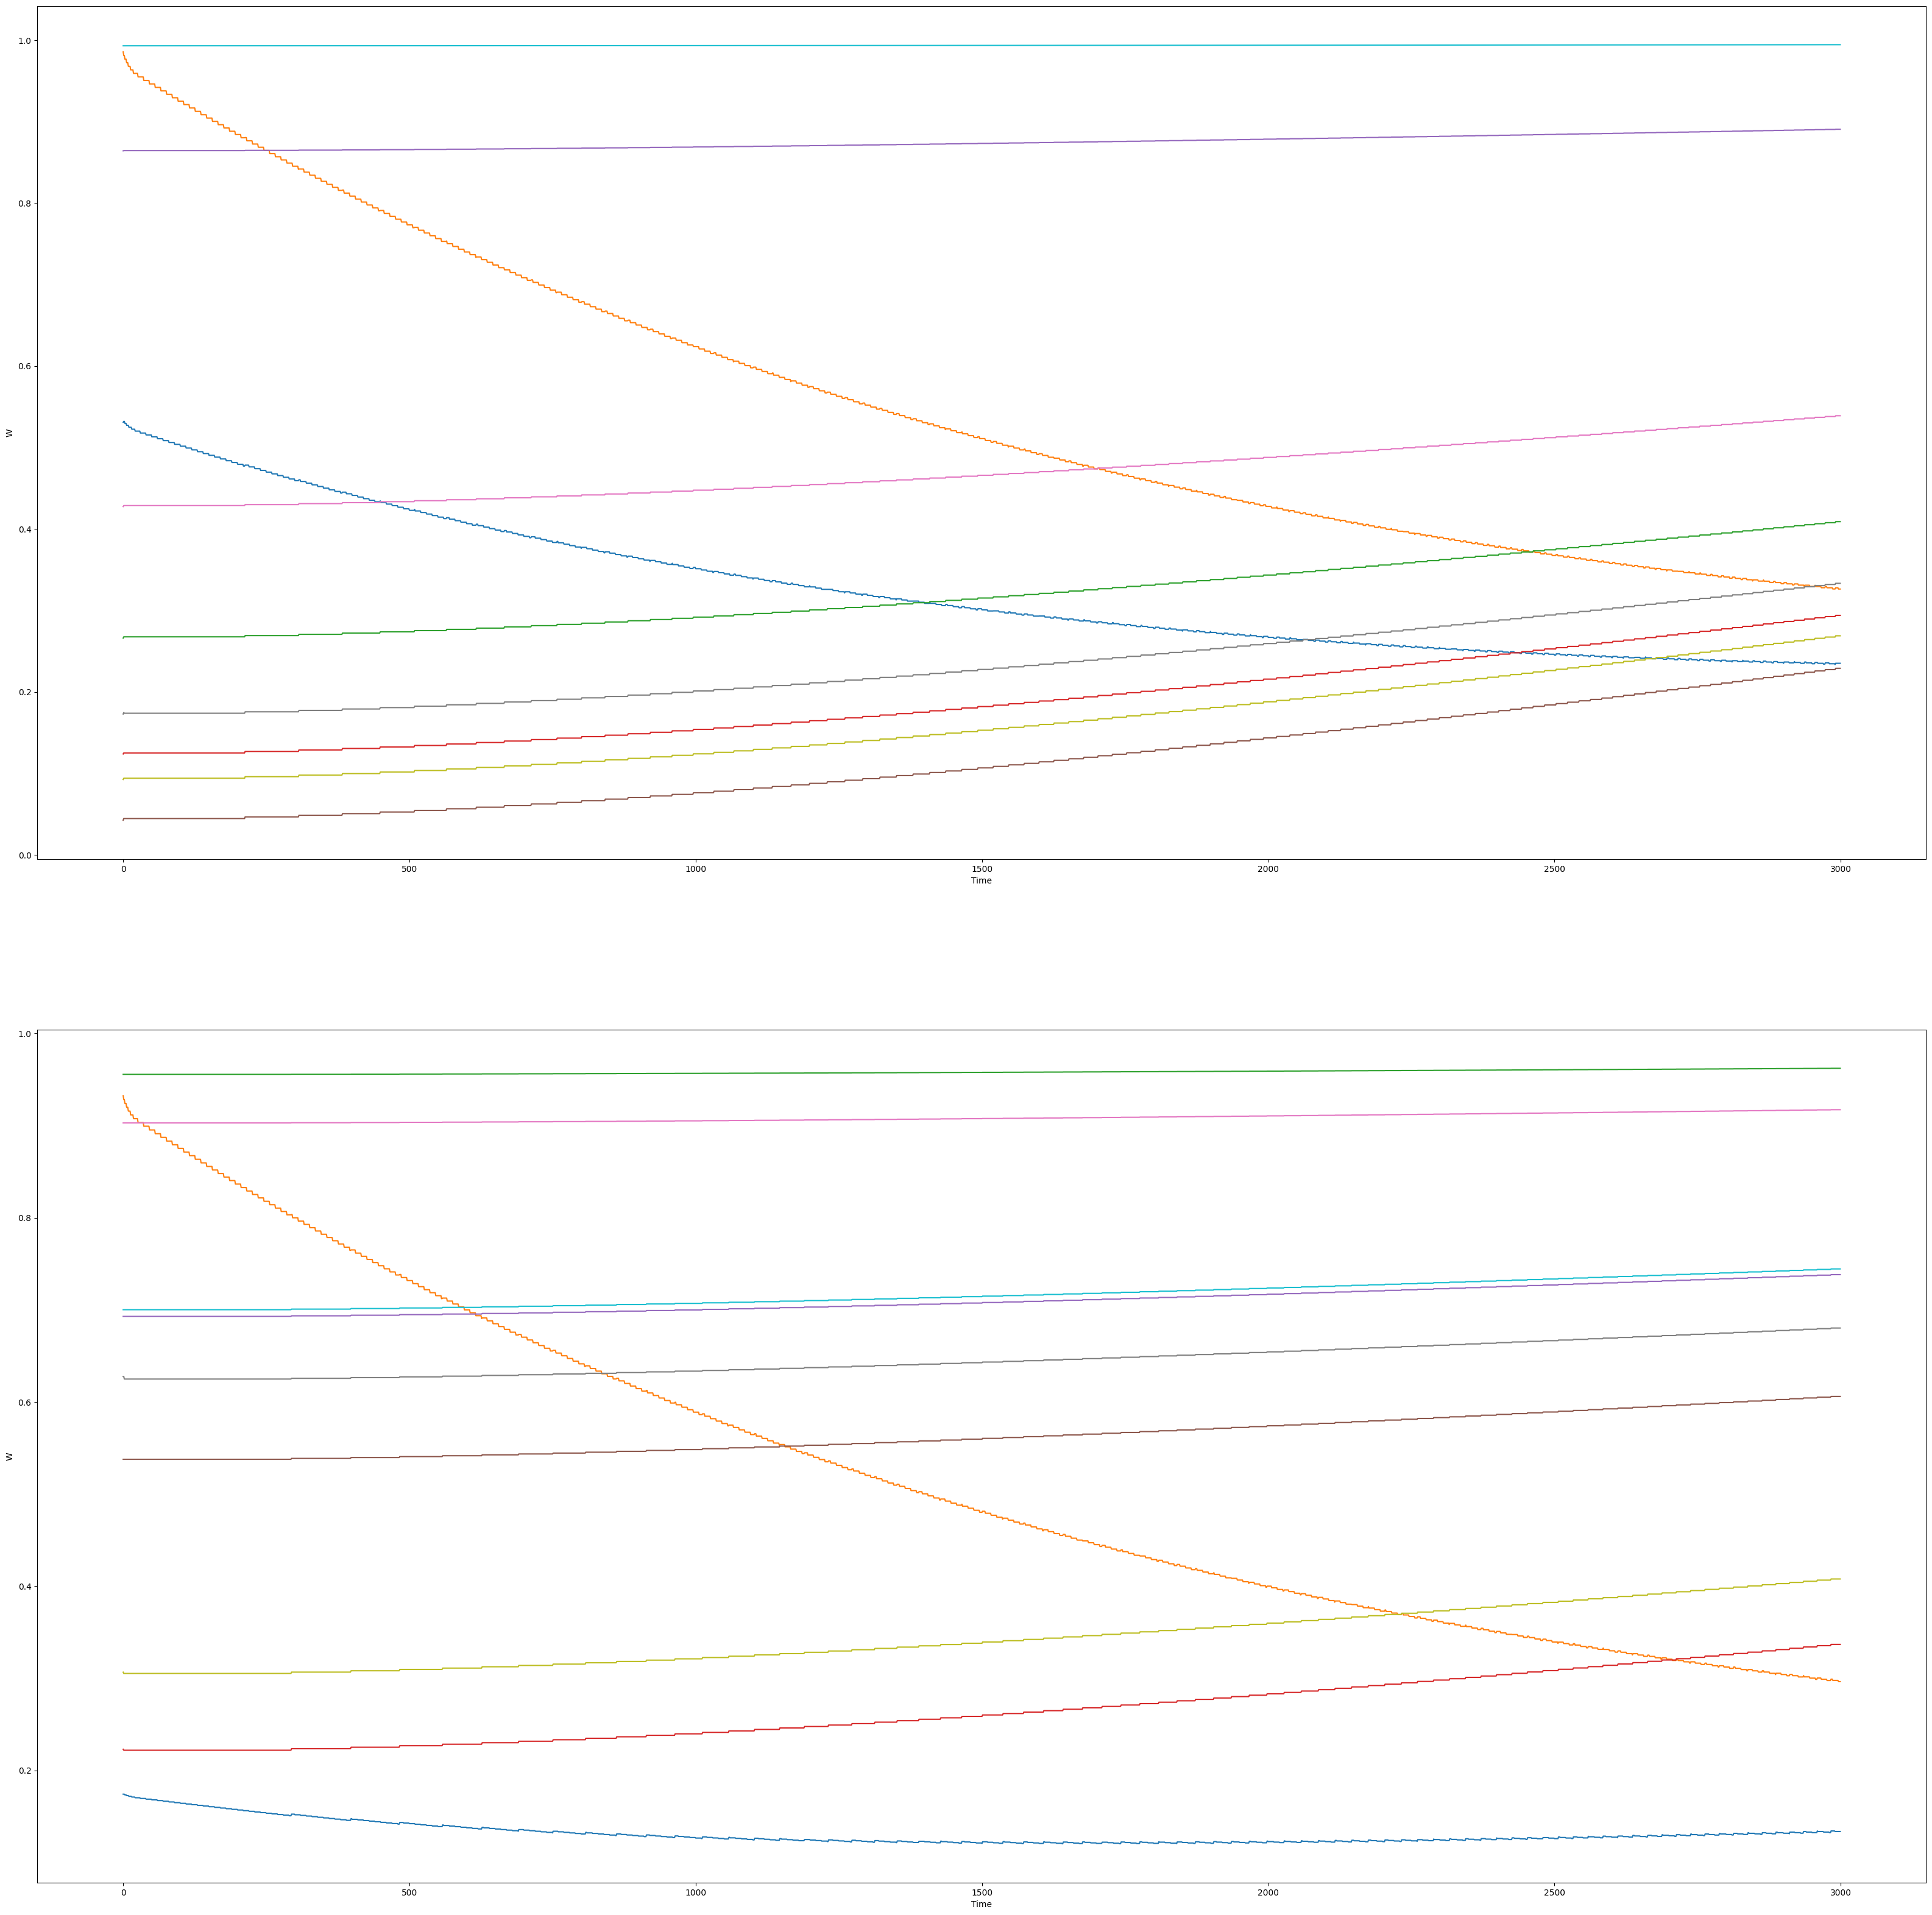

In [304]:
fig, axs = plt.subplots(2, figsize=(40,40))
time = np.arange(0, 3000, 1)

for i in range(2):
    for j in range(10):
        w = syn1['s.W', 0][:, j, i]
        axs[i].plot(time, w)
        axs[i].set(xlabel="Time", ylabel="W")
plt.show()